<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Cell/NO2_SCA.Cell.Mult.IDWexp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install netCDF4

In [2]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 49.4 MB/s eta 0:00:00


# Corrected - BaseCase

In [26]:
import netCDF4 as nc

# Define file paths
your_netcdf_path = "BaseCase_Corrected_NO2_Y_EXP_MUL.nc"  # Your  file
jrc_netcdf_path = "BaseCase_PERT_NO2_YEARLY.nc"  # JRC reference file

# Function to extract NetCDF structure
def get_netcdf_structure(filepath):
    with nc.Dataset(filepath, "r") as dataset:
        structure = {
            "dimensions": {dim: dataset.dimensions[dim].size for dim in dataset.dimensions},
            "variables": {var: dataset.variables[var].dimensions for var in dataset.variables},
            "attributes": {attr: dataset.getncattr(attr) for attr in dataset.ncattrs()}
        }
    return structure

# Extract structures
your_structure = get_netcdf_structure(your_netcdf_path)
jrc_structure = get_netcdf_structure(jrc_netcdf_path)

# Compare structures
print("\n=== DIMENSIONS COMPARISON ===")
print("Your File:", your_structure["dimensions"])
print("JRC File:", jrc_structure["dimensions"])

print("\n=== VARIABLES COMPARISON ===")
print("Your File:", list(your_structure["variables"].keys()))
print("JRC File:", list(jrc_structure["variables"].keys()))

print("\n=== GLOBAL ATTRIBUTES COMPARISON ===")
print("Your File:", your_structure["attributes"])
print("JRC File:", jrc_structure["attributes"])



=== DIMENSIONS COMPARISON ===
Your File: {'time': 1, 'lat': 781, 'lon': 521}
JRC File: {'lon': 521, 'lat': 781, 'time': 1}

=== VARIABLES COMPARISON ===
Your File: ['time', 'lat', 'lon', 'SURF_ug_NO2_corrected']
JRC File: ['lon', 'lat', 'time', 'SURF_ug_NO2']

=== GLOBAL ATTRIBUTES COMPARISON ===
Your File: {}
JRC File: {'vert_coord': 'atmosphere_hybrid_sigma_pressure_coordinate', 'Conventions': 'CF-1.6 for coordinates', 'model': 'EMEP_MSC-W', 'author_of_run': 'emepctm group', 'created_date': '20241118', 'created_hour': '091845.466', 'lastmodified_date': '20241122', 'lastmodified_hour': '084815.947', 'projection': 'lon lat', 'period_type': 'fullrun', 'run_label': 'Opensource_Setup_2020', 'history': 'Tue Jan  7 14:58:10 2025: ncrcat -v lon,lat,SURF_ug_NO2 EMEP45_CAMS61_WG5_Fairmode_BC_Perturbed_fullrun.nc BaseCase_PERT_NO2_YEARLY.nc', 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)'}


In [27]:
import netCDF4 as nc
import numpy as np
import shutil

# === Define File Paths ===
input_file = "BaseCase_Corrected_NO2_Y_EXP_MUL.nc"  # Your original file
output_file = "BaseCase_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc"  # Renamed final file
jrc_reference_file = "BaseCase_PERT_NO2_YEARLY.nc"  # JRC reference file

# === Backup Original File Before Modifying ===
shutil.copy(input_file, output_file)

# === Open Original NetCDF and Read Data ===
with nc.Dataset(input_file, "r") as src:

    # Read dimensions
    lon = src.variables["lon"][:]
    lat = src.variables["lat"][:]
    time = src.variables["time"][:]
    o3_data = src.variables["SURF_ug_NO2_corrected"][:]  # Read O3 data

    # Open new NetCDF file for writing with correct dimension order
    with nc.Dataset(output_file, "w", format="NETCDF4") as dst:

        # === Create Dimensions in Correct Order ===
        dst.createDimension("lon", len(lon))
        dst.createDimension("lat", len(lat))
        dst.createDimension("time", None)  # Keep time as unlimited

        # === Create Variables in Correct Order ===
        lon_var = dst.createVariable("lon", "f4", ("lon",))
        lat_var = dst.createVariable("lat", "f4", ("lat",))
        time_var = dst.createVariable("time", "f4", ("time",))
        o3_var = dst.createVariable("SURF_ug_NO2", "f4", ("lon", "lat", "time"), fill_value=-9999.0)

        # === Copy Attributes from Original File ===
        for attr in src.ncattrs():
            dst.setncattr(attr, src.getncattr(attr))

        # === Add Missing Global Attributes ===
        jrc_attributes = {
            "vert_coord": "atmosphere_hybrid_sigma_pressure_coordinate",
            "Conventions": "CF-1.6 for coordinates",
            "model": "EMEP_MSC-W",
            "author_of_run": "UoA",
            "created_date": "20250315",
            "created_hour": "091845.466",
            "lastmodified_date": "20241122",
            "lastmodified_hour": "084815.947",
            "projection": "lon lat",
            "period_type": "fullrun",
            "run_label": "Opensource_Setup_2025",
            "history": "Tue Jan 7 14:58:25 2025: ncrcat -v lon,lat,SURF_ug_NO2",
            "NCO": "netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)"
        }
        for attr, value in jrc_attributes.items():
            dst.setncattr(attr, value)

        # === Copy Variable Data (Reordered) ===
        lon_var[:] = lon
        lat_var[:] = lat
        time_var[:] = time
        o3_var[:, :, :] = np.transpose(o3_data, (2, 1, 0))  # Reorder from (time, lat, lon) to (lon, lat, time)

print(f" Correction completed! Renamed and fixed NetCDF saved as: {output_file}")

# === Function to Extract NetCDF Structure ===
def get_netcdf_structure(filepath):
    with nc.Dataset(filepath, "r") as dataset:
        structure = {
            "dimensions": {dim: dataset.dimensions[dim].size for dim in dataset.dimensions},
            "variables": {var: dataset.variables[var].dimensions for var in dataset.variables},
            "attributes": {attr: dataset.getncattr(attr) for attr in dataset.ncattrs()}
        }
    return structure

# Extract structures
your_structure = get_netcdf_structure(output_file)
jrc_structure = get_netcdf_structure(jrc_reference_file)

# === Compare Structures ===
print("\n=== DIMENSIONS COMPARISON ===")
print("Your File:", your_structure["dimensions"])
print("JRC File:", jrc_structure["dimensions"])

print("\n=== VARIABLES COMPARISON ===")
print("Your File:", list(your_structure["variables"].keys()))
print("JRC File:", list(jrc_structure["variables"].keys()))

print("\n=== GLOBAL ATTRIBUTES COMPARISON ===")
print("Your File:", your_structure["attributes"])
print("JRC File:", jrc_structure["attributes"])

print(" Final check completed! If all outputs match, your NetCDF is JRC-compliant.")



 Correction completed! Renamed and fixed NetCDF saved as: BaseCase_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc

=== DIMENSIONS COMPARISON ===
Your File: {'lon': 521, 'lat': 781, 'time': 1}
JRC File: {'lon': 521, 'lat': 781, 'time': 1}

=== VARIABLES COMPARISON ===
Your File: ['lon', 'lat', 'time', 'SURF_ug_NO2']
JRC File: ['lon', 'lat', 'time', 'SURF_ug_NO2']

=== GLOBAL ATTRIBUTES COMPARISON ===
Your File: {'vert_coord': 'atmosphere_hybrid_sigma_pressure_coordinate', 'Conventions': 'CF-1.6 for coordinates', 'model': 'EMEP_MSC-W', 'author_of_run': 'UoA', 'created_date': '20250315', 'created_hour': '091845.466', 'lastmodified_date': '20241122', 'lastmodified_hour': '084815.947', 'projection': 'lon lat', 'period_type': 'fullrun', 'run_label': 'Opensource_Setup_2025', 'history': 'Tue Jan 7 14:58:25 2025: ncrcat -v lon,lat,SURF_ug_NO2', 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)'}
JRC File: {'vert_coord': 'atmosphere_hybrid_sigma

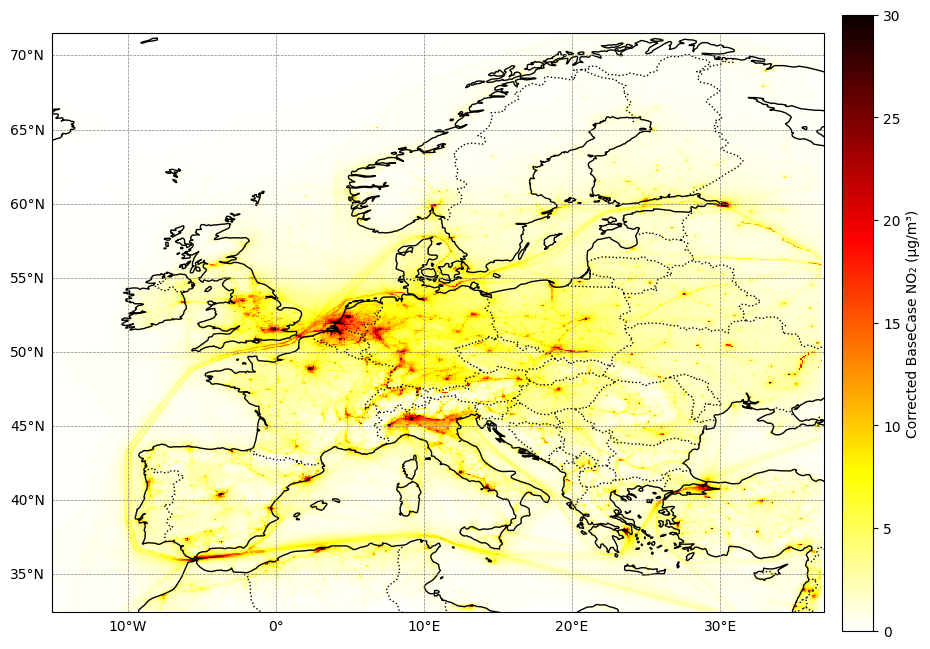

In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected NO₂ NetCDF File ===
corrected_netcdf_path = "BaseCase_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected NO₂ values
corrected_no2 = ds_corrected["SURF_ug_NO2"].squeeze().values.T

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Color Normalization Scale for NO₂ ===
norm = mcolors.Normalize(0, 30)  # Adjust scale for NO₂ concentration range (µg/m³)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the NO₂ concentration using pcolormesh
mesh = ax.pcolormesh(Lon, Lat, corrected_no2, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected BaseCase NO₂ (µg/m³)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()


# Corrected - ScenarioCase

In [29]:
import netCDF4 as nc

# Define file paths
your_netcdf_path = "Scenario_Corrected_NO2_Y_IDW_EXP_MUL.nc"  # Your  file
jrc_netcdf_path = "SCEN_PERT_NO2_YEARLY.nc"  # JRC reference file

# Function to extract NetCDF structure
def get_netcdf_structure(filepath):
    with nc.Dataset(filepath, "r") as dataset:
        structure = {
            "dimensions": {dim: dataset.dimensions[dim].size for dim in dataset.dimensions},
            "variables": {var: dataset.variables[var].dimensions for var in dataset.variables},
            "attributes": {attr: dataset.getncattr(attr) for attr in dataset.ncattrs()}
        }
    return structure

# Extract structures
your_structure = get_netcdf_structure(your_netcdf_path)
jrc_structure = get_netcdf_structure(jrc_netcdf_path)

# Compare structures
print("\n=== DIMENSIONS COMPARISON ===")
print("Your File:", your_structure["dimensions"])
print("JRC File:", jrc_structure["dimensions"])

print("\n=== VARIABLES COMPARISON ===")
print("Your File:", list(your_structure["variables"].keys()))
print("JRC File:", list(jrc_structure["variables"].keys()))

print("\n=== GLOBAL ATTRIBUTES COMPARISON ===")
print("Your File:", your_structure["attributes"])
print("JRC File:", jrc_structure["attributes"])



=== DIMENSIONS COMPARISON ===
Your File: {'time': 1, 'lat': 781, 'lon': 521}
JRC File: {'lon': 521, 'lat': 781, 'time': 1}

=== VARIABLES COMPARISON ===
Your File: ['time', 'lat', 'lon', 'SURF_ug_NO2_corrected']
JRC File: ['lon', 'lat', 'time', 'SURF_ug_NO2']

=== GLOBAL ATTRIBUTES COMPARISON ===
Your File: {}
JRC File: {'vert_coord': 'atmosphere_hybrid_sigma_pressure_coordinate', 'Conventions': 'CF-1.6 for coordinates', 'model': 'EMEP_MSC-W', 'author_of_run': 'emepctm group', 'created_date': '20241210', 'created_hour': '093230.774', 'lastmodified_date': '20241213', 'lastmodified_hour': '195348.818', 'projection': 'lon lat', 'period_type': 'fullrun', 'run_label': 'Opensource_Setup_2020', 'history': 'Tue Jan  7 15:01:16 2025: ncrcat -v lon,lat,SURF_ug_NO2 EMEP45_C61_WG5_BC_Pert_ALL50REDNew_fullrun.nc SCEN_PERT_NO2_YEARLY.nc', 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)'}


In [30]:
import netCDF4 as nc
import numpy as np
import shutil

# === Define File Paths ===
input_file = "Scenario_Corrected_NO2_Y_IDW_EXP_MUL.nc"  # Your original file
output_file = "Scen_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc"  # Renamed final file
jrc_reference_file = "SCEN_PERT_NO2_YEARLY.nc"  # JRC reference file

# === Backup Original File Before Modifying ===
shutil.copy(input_file, output_file)

# === Open Original NetCDF and Read Data ===
with nc.Dataset(input_file, "r") as src:

    # Read dimensions
    lon = src.variables["lon"][:]
    lat = src.variables["lat"][:]
    time = src.variables["time"][:]
    o3_data = src.variables["SURF_ug_NO2_corrected"][:]  # Read O3 data

    # Open new NetCDF file for writing with correct dimension order
    with nc.Dataset(output_file, "w", format="NETCDF4") as dst:

        # === Create Dimensions in Correct Order ===
        dst.createDimension("lon", len(lon))
        dst.createDimension("lat", len(lat))
        dst.createDimension("time", None)  # Keep time as unlimited

        # === Create Variables in Correct Order ===
        lon_var = dst.createVariable("lon", "f4", ("lon",))
        lat_var = dst.createVariable("lat", "f4", ("lat",))
        time_var = dst.createVariable("time", "f4", ("time",))
        o3_var = dst.createVariable("SURF_ug_NO2", "f4", ("lon", "lat", "time"), fill_value=-9999.0)

        # === Copy Attributes from Original File ===
        for attr in src.ncattrs():
            dst.setncattr(attr, src.getncattr(attr))

        # === Add Missing Global Attributes ===
        jrc_attributes = {
            "vert_coord": "atmosphere_hybrid_sigma_pressure_coordinate",
            "Conventions": "CF-1.6 for coordinates",
            "model": "EMEP_MSC-W",
            "author_of_run": "UoA",
            "created_date": "20250315",
            "created_hour": "091845.466",
            "lastmodified_date": "20241122",
            "lastmodified_hour": "084815.947",
            "projection": "lon lat",
            "period_type": "fullrun",
            "run_label": "Opensource_Setup_2025",
            "history": "Tue Jan 7 14:58:25 2025: ncrcat -v lon,lat,SURF_ug_NO2",
            "NCO": "netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)"
        }
        for attr, value in jrc_attributes.items():
            dst.setncattr(attr, value)

        # === Copy Variable Data (Reordered) ===
        lon_var[:] = lon
        lat_var[:] = lat
        time_var[:] = time
        o3_var[:, :, :] = np.transpose(o3_data, (2, 1, 0))  # Reorder from (time, lat, lon) to (lon, lat, time)

print(f" Correction completed! Renamed and fixed NetCDF saved as: {output_file}")

# === Function to Extract NetCDF Structure ===
def get_netcdf_structure(filepath):
    with nc.Dataset(filepath, "r") as dataset:
        structure = {
            "dimensions": {dim: dataset.dimensions[dim].size for dim in dataset.dimensions},
            "variables": {var: dataset.variables[var].dimensions for var in dataset.variables},
            "attributes": {attr: dataset.getncattr(attr) for attr in dataset.ncattrs()}
        }
    return structure

# Extract structures
your_structure = get_netcdf_structure(output_file)
jrc_structure = get_netcdf_structure(jrc_reference_file)

# === Compare Structures ===
print("\n=== DIMENSIONS COMPARISON ===")
print("Your File:", your_structure["dimensions"])
print("JRC File:", jrc_structure["dimensions"])

print("\n=== VARIABLES COMPARISON ===")
print("Your File:", list(your_structure["variables"].keys()))
print("JRC File:", list(jrc_structure["variables"].keys()))

print("\n=== GLOBAL ATTRIBUTES COMPARISON ===")
print("Your File:", your_structure["attributes"])
print("JRC File:", jrc_structure["attributes"])

print(" Final check completed! If all outputs match, your NetCDF is JRC-compliant.")


 Correction completed! Renamed and fixed NetCDF saved as: Scen_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc

=== DIMENSIONS COMPARISON ===
Your File: {'lon': 521, 'lat': 781, 'time': 1}
JRC File: {'lon': 521, 'lat': 781, 'time': 1}

=== VARIABLES COMPARISON ===
Your File: ['lon', 'lat', 'time', 'SURF_ug_NO2']
JRC File: ['lon', 'lat', 'time', 'SURF_ug_NO2']

=== GLOBAL ATTRIBUTES COMPARISON ===
Your File: {'vert_coord': 'atmosphere_hybrid_sigma_pressure_coordinate', 'Conventions': 'CF-1.6 for coordinates', 'model': 'EMEP_MSC-W', 'author_of_run': 'UoA', 'created_date': '20250315', 'created_hour': '091845.466', 'lastmodified_date': '20241122', 'lastmodified_hour': '084815.947', 'projection': 'lon lat', 'period_type': 'fullrun', 'run_label': 'Opensource_Setup_2025', 'history': 'Tue Jan 7 14:58:25 2025: ncrcat -v lon,lat,SURF_ug_NO2', 'NCO': 'netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)'}
JRC File: {'vert_coord': 'atmosphere_hybrid_sigma_pre

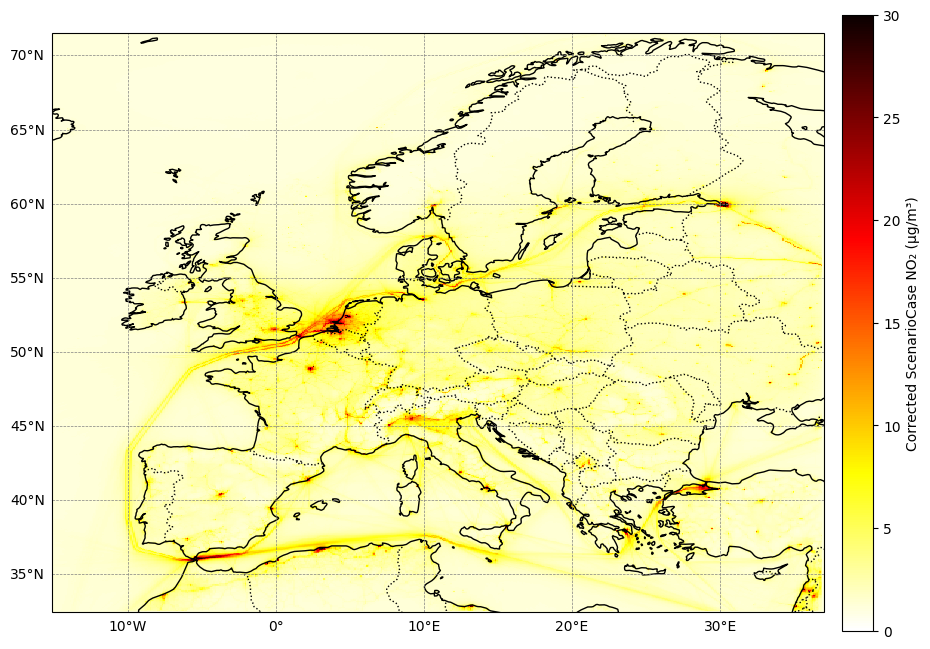

In [31]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected Scenario O₃ NetCDF File ===
corrected_netcdf_path = "Scen_UoA_NO2_SCA.Cell.Mult.IDWexp_CORR_YEARLY.nc"  # Adjust path if needed
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ scenario values
corrected_o3 = ds_corrected["SURF_ug_NO2"].squeeze().values.T

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 30)  # Adjust scale if needed

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the corrected O₃ scenario using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected ScenarioCase NO₂ (µg/m³)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()
